In [1]:
pip install kaggle

In [2]:
pip install tensorflow

In [3]:
pip install pydot

In [4]:
pip install opencv-python

In [5]:
%pip install opencv-python-headless

In [ ]:
!apt-get update

Reading package lists... Done
E: List directory /var/lib/apt/lists/partial is missing. - Acquire (13: Permission denied)


In [6]:
import os

# Set Kaggle API credentials using environment variables
os.environ['KAGGLE_USERNAME'] = 'dalalvansh'
os.environ['KAGGLE_KEY'] = '84fa862b69bcb8540a2189b194e7da0f'


In [7]:
!kaggle datasets download -d tinashri/brain-tumor-dataset-includes-the-mask-and-images

 99% 309M/312M [00:02<00:00, 124MB/s]
100% 312M/312M [00:02<00:00, 119MB/s]


In [8]:
import zipfile

# Specify the path to the downloaded zip file
zip_file_path = '/content/brain-tumor-dataset-includes-the-mask-and-images.zip'

# Specify the directory where you want to extract the contents
extract_to_directory = '/content/brain_tumor_dataset'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

# Optional: List the extracted files
extracted_files = os.listdir(extract_to_directory)
print("Extracted files:", extracted_files)


Extracted files: ['data', 'predict_all.py']


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split

In [10]:
# Define image and mask directories
image_directory = "brain_tumor_dataset/data/data/images/"
mask_directory = "brain_tumor_dataset/data/data/masks"

# Create lists of file paths for images and masks
image_file_paths = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory)]
mask_file_paths = [os.path.join(mask_directory, filename) for filename in os.listdir(mask_directory)]

# Split the lists into training and testing sets
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    image_file_paths, mask_file_paths, test_size=0.2, random_state=42
)
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
    return input_image, input_mask

def enhance_contrast(input_image):
    # Apply per-image standardization
    enhanced_image = tf.image.per_image_standardization(input_image)
    return enhanced_image

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32) / 255.0
    return input_image, input_mask

# Define functions to load images and masks from file and preprocess them
def load_image_and_mask(image_path, mask_path):
    input_image = tf.io.read_file(image_path)
    input_image = tf.image.decode_png(input_image, channels=3)
    input_mask = tf.io.read_file(mask_path)
    input_mask = tf.image.decode_png(input_mask, channels=1)
    input_image, input_mask = resize(input_image, input_mask)
    input_image=enhance_contrast(input_image)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask


# Create TensorFlow datasets from the lists of file paths
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths))

# Map the loading and preprocessing functions to the datasets
train_dataset = train_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
for image, mask in train_dataset.take(10):
    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)

Image shape: (128, 128, 3)
Mask shape: (128, 128, 1)
Image shape: (128, 128, 3)
Mask shape: (128, 128, 1)
Image shape: (128, 128, 3)
Mask shape: (128, 128, 1)
Image shape: (128, 128, 3)
Mask shape: (128, 128, 1)
Image shape: (128, 128, 3)
Mask shape: (128, 128, 1)
Image shape: (128, 128, 3)
Mask shape: (128, 128, 1)
Image shape: (128, 128, 3)
Mask shape: (128, 128, 1)
Image shape: (128, 128, 3)
Mask shape: (128, 128, 1)
Image shape: (128, 128, 3)
Mask shape: (128, 128, 1)
Image shape: (128, 128, 3)
Mask shape: (128, 128, 1)


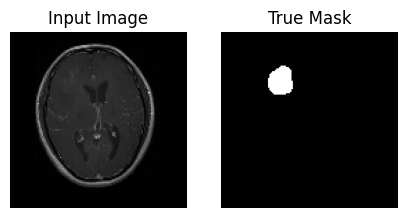

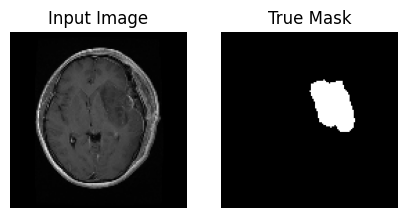

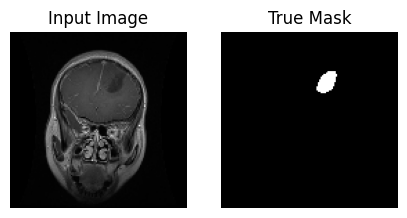

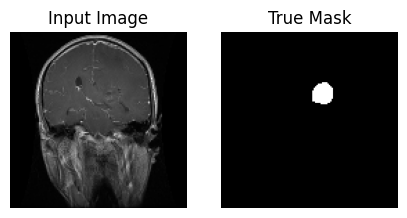

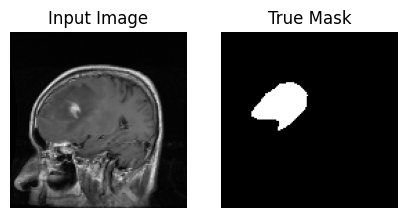

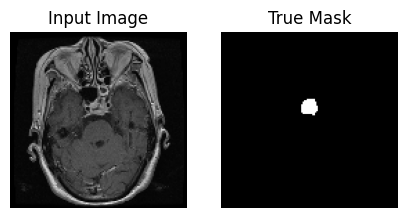

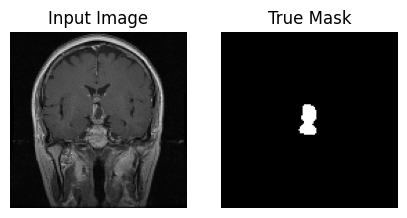

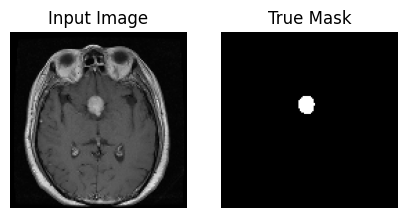

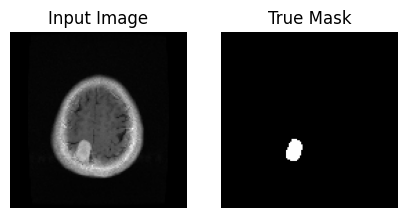

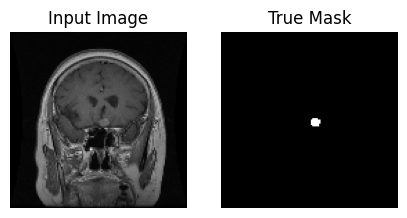

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def display(display_list):
    plt.figure(figsize=(5, 5))  # Adjust the figsize if needed
    title = ["Input Image", "True Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
        plt.axis("off")
    plt.show()

# Create an iterator for the test_batches dataset
test_iterator = iter(test_dataset.take(10))

# Iterate through batches and display images
for _ in range(10):  # You can change the range to display a different number of batches
    # Fetch a sample batch
    sample_batch = next(test_iterator)
    sample_image, sample_mask = sample_batch

    # Display the sample image and mask
    display([sample_image, sample_mask])

In [13]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [ ]:
import shutil
c="brain_tumor_dataset/data/data/masks/.ipynb_checkpoints"
if os.path.exists(c):
    shutil.rmtree(c)

## Build the U-Net Model

In [14]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [15]:
unet_model = build_unet_model()

In [16]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

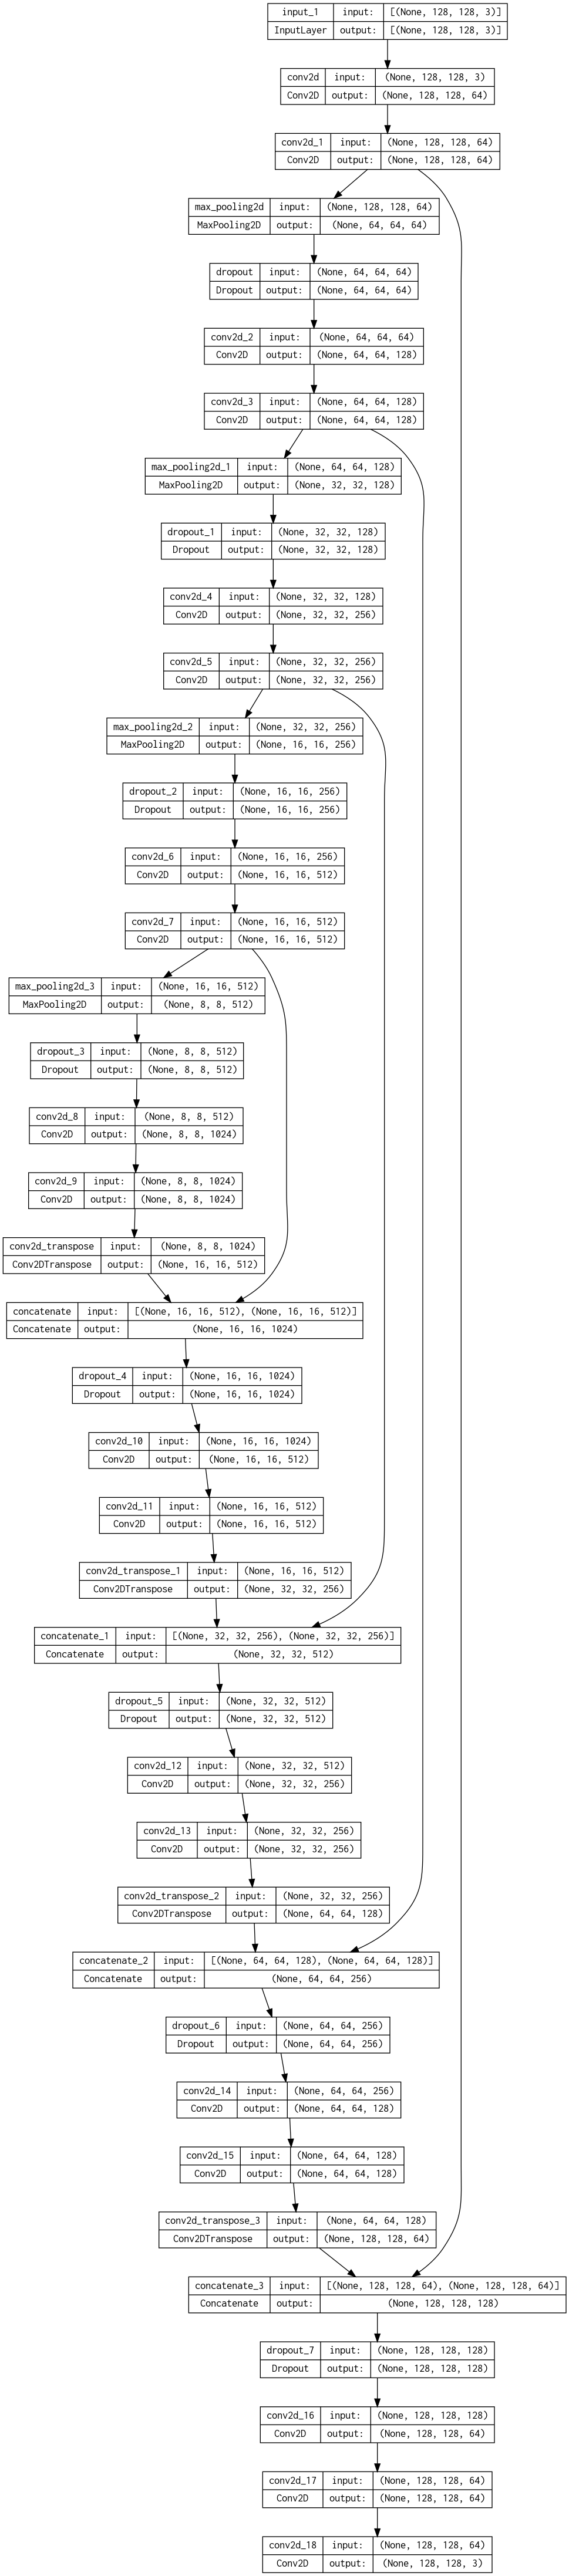

In [ ]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [17]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics="accuracy")

In [ ]:
NUM_EPOCHS = 100  # Set the number of epochs
BATCH_SIZE = 32
BUFFER_SIZE = 100

train_batches = train_dataset.take(2000).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_batches,len(train_batches))
validation_batches = train_dataset.skip(2000).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(validation_batches,len(validation_batches))

# Train the model with the modified parameters
model_history = unet_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                              validation_data=validation_batches )

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))> 63
<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))> 15
Epoch 1/100
 1/63 [..............................] - ETA: 1:02:29 - loss: 1.0971 - accuracy: 0.3336

In [ ]:
unet_model.save("")

2024-02-29 12:14:16.978437: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.
2024-02-29 12:14:16.986339: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.
2024-02-29 12:14:17.000029: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.
2024-02-29 12:14:17.005630: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.
2024-02-29 12:14:17.034993: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


In [ ]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

In [ ]:
# Display learning curves
display_learning_curves(unet_model.history)

KeyError: 'accuracy'

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display_2([image[0], mask[0], create_mask(pred_mask)])
    else:
        display_2([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
test_batches = test_dataset.take(613).batch(1)
count = 0
for i in test_batches:
    count +=1

print("number of batches:", count)

number of batches: 613


In [ ]:
def display_2(display_list):
    plt.figure(figsize=(5, 5))
    title = ["Input Image", "True Mask","Predicted_Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap = 'gray')
        plt.axis("off")
    plt.show()

1/1 [==============================] - 1s 1s/step


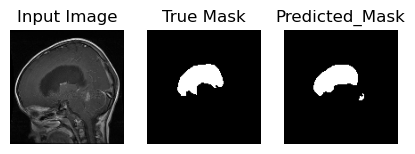

1/1 [==============================] - 0s 16ms/step


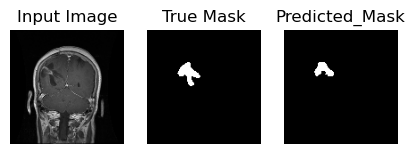

1/1 [==============================] - 0s 15ms/step


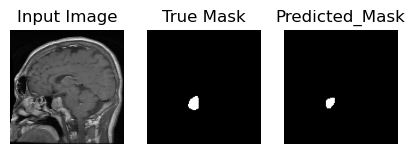

1/1 [==============================] - 0s 25ms/step


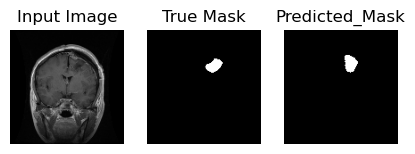

1/1 [==============================] - 0s 15ms/step


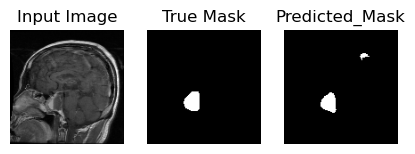

In [ ]:
show_predictions(test_batches.take(5), 5)